In [5]:
# importing the libraries
# basic stuff
import pandas as pd
import numpy as np
import math
import re
import nltk #swiss knife army for nlp
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
from tqdm import tqdm
from pymystem3 import Mystem

# nltk stemmers
stemmerRu = SnowballStemmer("russian") 
stemmerEn = PorterStemmer()
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering



In [3]:
# preprocessing function
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    #lem_words=[Mystem().lemmatize(w) for w in filtered_words]
    #stem_words=[stemmerRu.stem(w) for w in filtered_words]
    return " ".join(filtered_words)




In [2]:
#%time df.to_csv('/Users/apple/BDML/data/trained_clean.csv')
df = pd.read_csv(r'/Users/apple/BDML/data/trained_clean.csv')
df = df.drop(['Unnamed: 0', 'text'], axis = 1)
df.head()

,doc_id,clean
0,0,открыта вакансия составитель заявок рассмотрим...
1,1,неловкое чувство когдα боишься нαписαть челове...
2,2,нахуй нужна твоё отсутствие жизни делает люди ...
3,3,хотите уходите привыкать брат дома бесuт скуча...
4,4,представляете насколько весы нуждаются тепле л...


In [3]:
import artm


# creating the function for transformation to vowpal_wabbit format

def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='clean'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('|{0} '.format( namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', ' ').replace(':', ' '), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')



In [4]:
# changing the type of data created
vw = df_to_vw_regression(df, filepath='data_df.txt', target='doc_id')

73987it [00:11, 6661.42it/s]


In [5]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='data_df.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='batches2')

#batch_vectorizer = artm.BatchVectorizer(data_path='batches2', data_format='batches')


In [6]:
  # setting up dictionary
dictionary = batch_vectorizer.dictionary

In [7]:
number_of_topics = 60
topic_names = ['topic_{}'.format(i) for i in range(number_of_topics)]

# inial objects creation
model_artm = artm.ARTM(topic_names=topic_names,
                       cache_theta=True,
                       dictionary=dictionary, 
                       seed = 123,
                       show_progress_bars = True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary = dictionary))
#model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
#model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
#model_artm.scores.add(artm.TopTokensScore(name='Top_words', num_tokens=20, class_id='text'))
model_artm.scores.add(artm.TopTokensScore(name='top_words',num_tokens = 10))

# additional regulizers
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+4))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta', tau=- 0.05))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau= 0.3, topic_names= topic_names))#[35:]))

#setting up the number of tokens
model_artm.num_document_passes = 10

#initializing the model we've set up
model_artm.initialize(dictionary=dictionary)

In [8]:
# fitting the model
%time model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=16)


CPU times: user 1h 30min 26s, sys: 2min 17s, total: 1h 32min 44s
Wall time: 18min 16s


In [39]:
# phi and theta
artm_phi = model_artm.get_phi()
artm_theta = model_artm.get_theta()
## top_tokens
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print ('\n',topic_name)
    for (token, weight) in zip(top_tokens.last_tokens[topic_name][:number_of_topics],top_tokens.last_weights[topic_name][:number_of_topics]):
        print (token, '-', weight)


 topic_0
цена - 0.012518704868853092
наличии - 0.011896690353751183
руб - 0.009832998737692833
цвет - 0.006364929955452681
рублей - 0.0056762173771858215
цвета - 0.005186707247048616
заказ - 0.004840677138417959
размер - 0.004179018549621105
размеры - 0.00391771225258708
материал - 0.0035426041577011347

 topic_1
срок - 0.009537801146507263
лет - 0.008417372591793537
доставка - 0.006420993246138096
года - 0.005376922432333231
права - 0.005079893860965967
дней - 0.0048171766102313995
размере - 0.0045396145433187485
случае - 0.004088988993316889
суд - 0.003982226364314556
рублей - 0.003683647606521845

 topic_2
день - 0.013244856148958206
сегодня - 0.011520991101861
стоит - 0.005784454755485058
дня - 0.004500417970120907
постарайтесь - 0.0044370414689183235
отношения - 0.004127827472984791
работа - 0.0035052539315074682
возможно - 0.003435312770307064
дела - 0.003052842104807496
здоровье - 0.003041259478777647

 topic_3
делать - 0.007886339910328388
вопрос - 0.006343554705381393
лет - 0

Text(0, 0.5, 'perplexity score')

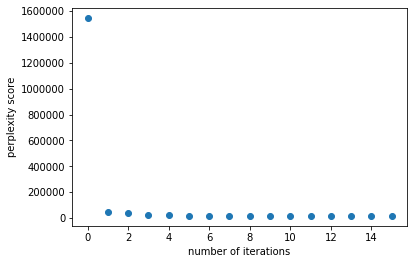

In [40]:
perplexityScore = list(model_artm.score_tracker['PerplexityScore'].value)

%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

# visualizing perplexity
plt.scatter(range(len(perplexityScore)), perplexityScore)
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

In [41]:
lables = dict()
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist


# lemmatisation of top tokens

for topic_name in model_artm.topic_names:
    
    lables[topic_name] = ' '.join(word for word in top_tokens.last_tokens[topic_name][0:6])
    lables[topic_name] = ''.join(Mystem().lemmatize(lables[topic_name]))
    lables[topic_name] = ' '.join(unique_list(lables[topic_name].split()))
    
    print(lables[topic_name])
    
    artm_theta.rename({topic_name:lables[topic_name]}, inplace = True)

    
lables

цена наличие руб цвет рубль
срок год доставка право день
день сегодня стоять постараться отношение
делать вопрос год поэтому часто ставить
игра матч футбол команда мир
гороскоп сегодня рождаться июнь август июль
радоваться бог господь христос
область год россия район город дтп
хотеть лайк нахуй любить блять репост
ребенок жизнь
деньги день человек жизнь год
год век дизайн место дом музей
озеро город мир метр остров парк
волос sex big tits anal
что это как так я ты
від ціна або але характеристика буде
iphone apple видео новый android google
человек жизнь ремарк
альбом amp love рок группа
руб работа тело требоваться дом квартира
человек бизнес жизнь должный
год мама сказать говорить дверь домой
день нога мышца упражнение тело
почему сегодня день делать знать говорить
минута масло вода затем добавлять
ученый год иметь собака длина
хотеть любовь друг жизнь рядом
человек лишь смерть мир
несколько становиться дома снова смерть
человек имя энергия деньги жизнь сила
год сша нью
человек любить 

{'topic_0': 'цена наличие руб цвет рубль',
 'topic_1': 'срок год доставка право день',
 'topic_2': 'день сегодня стоять постараться отношение',
 'topic_3': 'делать вопрос год поэтому часто ставить',
 'topic_4': 'игра матч футбол команда мир',
 'topic_5': 'гороскоп сегодня рождаться июнь август июль',
 'topic_6': 'радоваться бог господь христос',
 'topic_7': 'область год россия район город дтп',
 'topic_8': 'хотеть лайк нахуй любить блять репост',
 'topic_9': 'ребенок жизнь',
 'topic_10': 'деньги день человек жизнь год',
 'topic_11': 'год век дизайн место дом музей',
 'topic_12': 'озеро город мир метр остров парк',
 'topic_13': 'волос sex big tits anal',
 'topic_14': 'что это как так я ты',
 'topic_15': 'від ціна або але характеристика буде',
 'topic_16': 'iphone apple видео новый android google',
 'topic_17': 'человек жизнь ремарк',
 'topic_18': 'альбом amp love рок группа',
 'topic_19': 'руб работа тело требоваться дом квартира',
 'topic_20': 'человек бизнес жизнь должный',
 'topic_21

In [42]:
artm_theta

,40000,40001,40002,40003,40004,40005,40006,40007,40008,40009,...,32990,32991,32992,32993,32994,32995,32996,32997,32998,32999
цена наличие руб цвет рубль,7.242944e-07,7.538535e-03,1.299831e-03,2.812391e-02,8.021856e-11,6.508457e-06,1.790944e-15,1.143872e-03,3.696406e-05,8.309098e-03,...,5.226500e-08,4.330704e-03,5.361094e-06,1.993062e-03,1.622421e-01,7.355812e-03,1.690274e-06,7.409523e-02,8.972153e-07,2.360699e-03
срок год доставка право день,2.616570e-09,8.119047e-05,1.419401e-12,4.078758e-07,3.246413e-04,7.118502e-07,0.000000e+00,2.924255e-03,2.674542e-03,7.092351e-03,...,1.245378e-12,1.359755e-03,2.573402e-05,1.605230e-02,9.414730e-05,2.876220e-02,0.000000e+00,9.941250e-05,4.306145e-03,1.229923e-05
день сегодня стоять постараться отношение,2.361151e-10,3.010958e-03,5.141878e-12,8.868762e-03,2.451851e-03,1.084256e-07,0.000000e+00,1.922761e-04,8.871257e-04,7.514147e-04,...,7.869214e-06,1.039983e-03,7.587790e-03,6.586656e-03,3.150421e-04,1.102298e-07,0.000000e+00,7.498988e-02,1.367524e-03,1.887247e-02
делать вопрос год поэтому часто ставить,3.004034e-09,1.718057e-01,1.105050e-09,4.986942e-03,5.108591e-02,1.038139e-02,3.792502e-10,2.643620e-05,1.105996e-01,1.411061e-03,...,1.998763e-06,1.173362e-04,1.811013e-02,5.951229e-04,3.118144e-04,6.319890e-04,0.000000e+00,3.136380e-04,3.719867e-02,3.215169e-04
игра матч футбол команда мир,9.472485e-06,1.303643e-05,8.988513e-13,4.257742e-06,2.246192e-03,2.137616e-06,0.000000e+00,6.040015e-04,1.399123e-06,6.211346e-07,...,3.546110e-03,1.433572e-02,9.910262e-06,1.925898e-03,2.174969e-04,2.318466e-08,3.638636e-08,1.775211e-03,9.015414e-05,2.047793e-05
гороскоп сегодня рождаться июнь август июль,1.355620e-07,2.482641e-03,4.087444e-15,4.311902e-04,1.582990e-05,2.525836e-04,1.010245e-14,4.795813e-03,5.547125e-05,3.741096e-05,...,6.051419e-11,6.829959e-05,4.042121e-04,1.811483e-04,3.067832e-05,3.586942e-10,0.000000e+00,6.937966e-04,1.116998e-04,1.650106e-03
радоваться бог господь христос,4.128416e-03,3.667957e-06,1.259932e-14,3.871574e-03,2.310322e-05,9.962418e-11,0.000000e+00,2.719764e-05,2.466005e-04,5.070733e-10,...,5.814191e-10,1.100572e-08,1.526166e-05,1.325536e-04,2.510957e-06,4.994246e-06,1.110569e-11,1.797673e-08,3.038783e-03,6.848804e-06
область год россия район город дтп,1.607080e-05,6.080516e-06,4.992004e-09,1.739548e-04,4.024012e-10,2.015299e-08,0.000000e+00,1.685843e-06,6.573048e-05,5.366681e-05,...,4.507450e-02,3.913984e-02,8.949767e-05,2.477430e-01,2.356384e-04,2.170255e-02,6.354664e-08,2.108620e-03,1.199132e-01,8.713996e-07
хотеть лайк нахуй любить блять репост,5.466246e-10,1.932508e-03,5.504843e-13,9.182800e-04,8.211651e-03,1.030497e-05,4.729339e-08,6.729612e-02,1.081097e-02,3.034837e-03,...,1.673457e-02,1.059726e-01,8.356803e-03,1.621091e-03,1.776476e-05,5.813370e-02,5.353373e-12,3.604647e-08,2.013737e-05,5.070931e-07
ребенок жизнь,1.931016e-11,2.525906e-02,6.574320e-04,9.602929e-03,4.352665e-02,1.607407e-07,6.375624e-10,1.235649e-03,2.464553e-02,1.233655e-03,...,1.431623e-06,9.047557e-06,7.896972e-03,1.904963e-03,1.367806e-01,2.448288e-06,6.501139e-15,3.587776e-04,1.926848e-04,7.018289e-02


In [43]:

odd_themes = [
    
               'человек именно часто являться',
               'человек жизнь сегодня жить лишь',
               'человек жизнь значит твой',
               'сегодня друг день группа утро добрый',
               'человек любить жизнь',
               'человек лишь смерть мир',
               'что это как так я ты',
               'почему сегодня день делать знать говорить',
               'деньги день человек жизнь год',
               'делать вопрос год поэтому часто ставить',
               'несколько становиться дома снова смерть'
    
              ]

theta_transposed.drop(columns = odd_themes)

#theta_transposed.to_csv('theta_transposed.csv')
#theta_transposed = pd.read_csv(r'theta_transposed.csv')

df['theme'] = theta_transposed.idxmax(axis=1)
df.head()

,doc_id,clean,theme,_id
0,0,открыта вакансия составитель заявок рассмотрим...,руб работа тело требоваться дом квартира,-171585368
1,1,неловкое чувство когдα боишься нαписαть челове...,человек любить жизнь,-171404269
2,2,нахуй нужна твоё отсутствие жизни делает люди ...,хотеть лайк нахуй любить блять репост,-171378742
3,3,хотите уходите привыкать брат дома бесuт скуча...,хотеть лайк нахуй любить блять репост,-171324398
4,4,представляете насколько весы нуждаются тепле л...,человек жизнь сегодня жить лишь,-171288949


In [3]:
group_user = pd.read_csv(r'/Users/apple/BDML/data/group_user.csv')
lables = pd.read_csv(r'/Users/apple/BDML/data/train_ids.csv')


In [45]:
df = df.merge(lables, on = 'doc_id')
df.theme.unique()

array(['руб работа тело требоваться дом квартира', 'человек любить жизнь',
       'хотеть лайк нахуй любить блять репост',
       'человек жизнь сегодня жить лишь',
       'любить глаз лишь снова сердце твой', 'компания рубль год млн',
       'что это как так я ты',
       'почему сегодня день делать знать говорить',
       'женщина муж жена мужчина спать', 'год век дизайн место дом музей',
       'хотеть любовь друг жизнь рядом',
       'продавать цена размер руб отдавать состояние',
       'iphone apple видео новый android google',
       'область год россия район город дтп',
       'сегодня друг день группа утро добрый',
       'ученый год иметь собака длина', 'день нога мышца упражнение тело',
       'хотеть писать искать друг фото год',
       'год мама сказать говорить дверь домой',
       'цена наличие руб цвет рубль', 'альбом amp love рок группа',
       'игра матч футбол команда мир', 'год сша нью',
       'озеро город мир метр остров парк',
       'жизнь любовь мир счастие жи

In [47]:
interests = group_user \
    .merge(df,left_on = 'group', right_on = '_id' ) \
    .drop(['clean', 'doc_id'], axis = 1) \
    .sort_values('user')

interests = interests.reset_index()

In [48]:

interests = interests.pivot_table(index = 'user', columns='theme') \
    .replace(np.nan, 0) 

    

In [49]:
interests.head()

_id_x  \
theme     bmw ряд петля mercedes лицо ford   
user                                         
138                                    0.0   
175                                    0.0   
176                                    0.0   
200                                    0.0   
252                                    0.0   
609                                    0.0   
713                                    0.0   
882                                    0.0   
936                                    0.0   
964                                    0.0   
1112                                   0.0   
1139                                   0.0   
1221                                   0.0   
1301                                   0.0   
1483                                   0.0   
1683                                   0.0   
1701                                   0.0   
2023                                   0.0   
2031                                   0.0   
2076                                   0.0   
2124                                   0.0   
2158                                   0.0   
2214                                   0.0   
2340                                   0.0   
2352                                   0.0   
2376                                   0.0   
2495                                   0.0   
2611                                   0.0   
2738                                   0.0   
2765                                   0.0   
...                                    ...   
440144209                              0.0   
440153261                              0.0   
440184247                              0.0   
440366514                              0.0   
440496039                              0.0   
440591364                              0.0   
440928808                              0.0   
440976066                              0.0   
441102910                              0.0   
441120732                              0.0   
441217423                              0.0   
441314164                              0.0   
441339414                              0.0   
441461003                              0.0   
441566330                              0.0   
441579113                              0.0   
441764935                              0.0   
441873957                              0.0   
441933226                              0.0   
442401256                              0.0   
442574664                              0.0   
442847876                              0.0   
442881491                              0.0   
442904635                              0.0   
442971935                              0.0   
443148104                              0.0   
443202777                              0.0   
443212325                              0.0   
443331124                              0.0   
443374184                              0.0   

                                                   \
theme     iphone apple видео новый android google   
user                                                
138                                  0.000000e+00   
175                                 -4.510653e+07   
176                                 -1.338874e+08   
200                                  0.000000e+00   
252                                  0.000000e+00   
609                                  0.000000e+00   
713                                  0.000000e+00   
882                                 -5.486442e+06   
936                                  0.000000e+00   
964                                  0.000000e+00   
1112                                 0.000000e+00   
1139                                 0.000000e+00   
1221                                 0.000000e+00   
1301                                 0.000000e+00   
1483                                 0.000000e+00   
1683                                 0.000000e+00   
1701                                 0.000000e+00   
2023                            

In [20]:
# creating age groups
vk_user = pd.read_csv(r'/Users/apple/BDML/data/vk_profiles.csv')
age_sex = vk_user.loc[:, :'sex']
age_sex['age_group'] = pd.cut(age_sex.age, [0, 14, 20, 27, 36, 45, 54, 63, 72, 81])
#age_sex.head()

cut = age_sex
cut['count'] = 1
cut.pivot_table('count', index='age_group', columns='sex', aggfunc='sum')


/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


sex,0,1
age_group,,
"(0, 14]",8,5
"(14, 20]",64,88
"(20, 27]",2676,2713
"(27, 36]",5910,8152
"(36, 45]",5091,7581
"(45, 54]",3518,4123
"(54, 63]",2585,2098
"(63, 72]",830,525
"(72, 81]",80,94


In [ ]:
ias = age_sex.merge(interests, left_on= 'doc_id', right_on= 'id')

grouping = dict()
groups = age_sex.age_groups.unique()
for o in range(2):
    for i in groups:
        grouping[str(i)+str(o)] = age_sex.loc[age_sex['sex'] == o and age_sex['age'] == i]
    

In [ ]:

ingroup_clusters = dict()
for a in grouping:
    ingroup_clusters[a] = AgglomerativeClustering(n_clusters=5, 
                                                  affinity='euclidean', 
                                                  linkage='ward') \
        .fit(a)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(ingroup_clusters['(72, 81]1'], 
                        ingroup_clusters['(72, 81]0']))